<a href="https://colab.research.google.com/github/AntonJohansson02/SolarProjectGbg-/blob/main/SolarPredictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [567]:
#@title
# Använder seaborn för att måla upp grafer
!pip install -q seaborn

In [511]:
# Importerar biblioteken som ska användas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


# Gör numpy enklare att läsa
np.set_printoptions(precision=3, suppress=True)

In [512]:
# Keras är ett program som gör det enklare att programmera artificiella neurala nätverk. (förenkling). 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
print(tf.__version__)

2.4.0


In [513]:
# Samla in datan från github och organisera den
url = 'https://raw.githubusercontent.com/AntonJohansson02/SolarProjectGbg-/main/G%C3%B6teborgSoltimmar_Aspv%C3%A4genProduktion_201712_Onwards_v5.csv'
column_names = ['Day','Month','Year', 'SolarHours', 'Temperature', 'Rain', 'AirPressure', 'Humidity', 'EnergyProduction' ]
raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=';', header=0, skipinitialspace=True)

In [514]:
# Skriv ut datan från toppen, första 20 raderna 
dataset = raw_dataset.copy()
dataset.head(20)

,Day,Month,Year,SolarHours,Temperature,Rain,AirPressure,Humidity,EnergyProduction
0,1,12,2017,0.00,1.687500,0.0,1016.037500,89.250000,646
1,2,12,2017,0.00,5.025000,4.2,1015.862500,89.833333,596
2,3,12,2017,2.38,6.416667,0.0,1009.345833,77.875000,2248
3,4,12,2017,5.91,4.562500,0.4,1016.404167,75.375000,1497
4,5,12,2017,0.00,7.287500,3.1,1012.404167,90.958333,1019
5,6,12,2017,0.00,7.720833,5.9,1008.833333,94.291667,101
6,7,12,2017,0.00,7.425000,2.6,995.400000,92.625000,20
7,8,12,2017,0.00,5.608333,0.0,986.137500,79.458333,1053
8,9,12,2017,0.69,5.316667,0.3,988.929167,67.333333,1712
9,10,12,2017,0.72,2.654167,5.7,986.762500,86.333333,1363


In [515]:
# kolla hur många okända variabler datan innehåller 
dataset.isna().sum()

Day                 0
Month               0
Year                0
SolarHours          0
Temperature         0
Rain                0
AirPressure         0
Humidity            0
EnergyProduction    0
dtype: int64

In [516]:
# ta bort dessa okända variabler
dataset = dataset.dropna()

In [517]:
# dela upp datan i träningsdata och testdata 
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

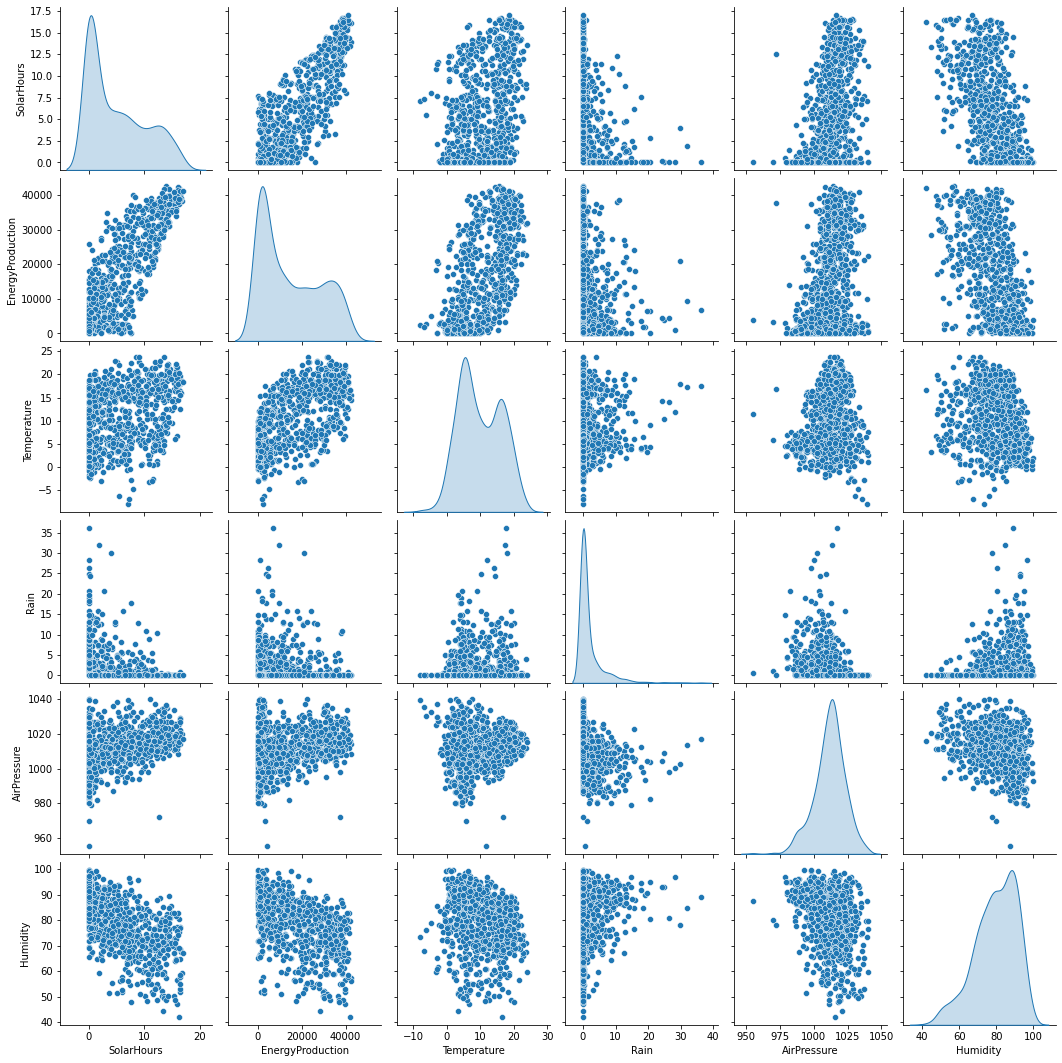

In [566]:
# inspektera datan för att få en överblick
sns.pairplot(train_dataset[['SolarHours', 'EnergyProduction', 'Temperature', 'Rain', 'AirPressure', 'Humidity' ]], diag_kind='kde')

In [519]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Day,902.0,15.605322,8.770821,1.000000,8.000000,16.000000,23.000000,31.000000
Month,902.0,6.662971,3.521228,1.000000,4.000000,7.000000,10.000000,12.000000
Year,902.0,2018.946785,0.867111,2017.000000,2018.000000,2019.000000,2020.000000,2020.000000
SolarHours,902.0,5.037406,5.181991,0.000000,0.050000,3.565000,9.027500,17.080000
Temperature,902.0,9.895778,6.291323,-8.062500,4.838542,9.002083,15.557292,23.795833
Rain,902.0,2.032373,4.204376,0.000000,0.000000,0.000000,2.175000,36.200000
AirPressure,902.0,1011.695741,11.305528,955.237500,1005.565625,1012.683333,1018.767708,1040.250000
Humidity,902.0,79.586151,11.275145,41.833333,72.270833,80.812500,88.781250,99.750000
EnergyProduction,902.0,14723.041020,13438.219874,0.000000,1830.750000,10963.500000,26931.000000,42683.000000


In [520]:
# Dela upp label från features, label är svaret och fetures är datan den ska gissa med
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('EnergyProduction')
test_labels = test_features.pop('EnergyProduction')

In [521]:
# Förarbeta datan, preprocessing, skapa först lagret 
normalizer = preprocessing.Normalization()

In [522]:
# adaptera den till datan
normalizer.adapt(np.array(train_features))

In [523]:
# räknar ut medelvärdet och spridningen och lagrar dem i lagret
print(normalizer.mean.numpy())

[  15.605    6.663 2018.947    5.037    9.896    2.032 1011.696   79.586]


In [524]:
# när lagret anropas så returnerar den input datan där varje del är normaliserad. 
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[  20.      4.   2020.     13.46    8.38    0.   1029.73   76.42]]

Normalized: [[ 0.5  -0.76  1.22  1.63 -0.24 -0.48  1.6  -0.28]]


**Linear regression** Vi börjar först med att gissa produktionen enligt en linjär funktion med endast en variabel, soltimmar.

In [525]:
solarhours = np.array(train_features['SolarHours'])

solarhours_normalizer = preprocessing.Normalization(input_shape=[1,])
solarhours_normalizer.adapt(solarhours)

In [526]:
solarhours_model = tf.keras.Sequential([
    solarhours_normalizer,
    layers.Dense(units=1)
])

solarhours_model.summary()

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_17 (Normalizat (None, 1)                 3         
_________________________________________________________________
dense_153 (Dense)            (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [527]:
solarhours_model.predict(solarhours[:10])

array([[-1.719],
       [-1.331],
       [ 0.906],
       [ 1.028],
       [ 0.92 ],
       [-0.333],
       [ 1.028],
       [-0.815],
       [-1.693],
       [ 0.189]], dtype=float32)

In [528]:
solarhours_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [529]:
%%time
history = solarhours_model.fit(
    train_features['SolarHours'], train_labels,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 9.21 s, sys: 282 ms, total: 9.49 s
Wall time: 8.86 s


In [530]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,14446.573242,14790.650391,95
96,14444.477539,14788.527344,96
97,14442.386719,14786.397461,97
98,14440.286133,14784.289062,98
99,14438.198242,14782.161133,99


In [531]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 20000])
  plt.xlabel('Epoch')
  plt.ylabel('Error [EnergyProduction]')
  plt.legend()
  plt.grid(True)

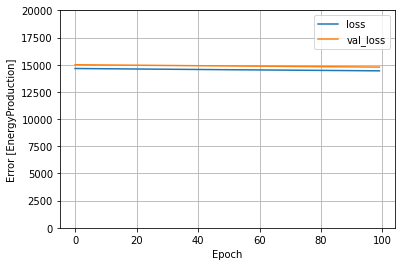

In [532]:
plot_loss(history)

In [533]:
test_results = {}

test_results['solarhours_model'] = solarhours_model.evaluate(
    test_features['SolarHours'],
    test_labels, verbose=0)

In [534]:
x = tf.linspace(0.0, 50, 51)
y = solarhours_model.predict(x)

In [535]:
def plot_solarhours(x, y):
  plt.scatter(train_features['SolarHours'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Solar Hours')
  plt.ylabel('Energy Production')
  plt.legend()

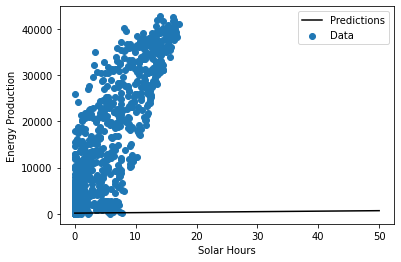

In [536]:
plot_solarhours(x,y)

**Multiple Inputs** Vi gissar produktionen med soltimar och datum enligt en linjär funktion. 

In [537]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [538]:
linear_model.predict(train_features[:10])

array([[ 0.933],
       [ 0.973],
       [ 1.497],
       [ 0.416],
       [-1.99 ],
       [-0.274],
       [-3.364],
       [ 0.544],
       [ 1.138],
       [-0.49 ]], dtype=float32)

In [539]:
linear_model.layers[1].kernel

<tf.Variable 'dense_154/kernel:0' shape=(8, 1) dtype=float32, numpy=
array([[ 0.406],
       [-0.44 ],
       [ 0.063],
       [-0.476],
       [ 0.744],
       [-0.559],
       [ 0.516],
       [-0.638]], dtype=float32)>

In [540]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [541]:
%%time
history = linear_model.fit(
    train_features, train_labels, 
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 9.6 s, sys: 329 ms, total: 9.93 s
Wall time: 9.2 s


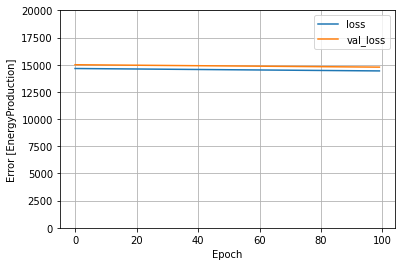

In [542]:
plot_loss(history)

In [543]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

**DNN Regression** Nu använder vi soltimmar för att gissa produktionen men denna gången använder vi fler lager som inte behöver vara linjära, kallas DNN (Deconvolutional Neural Network) modell. 

In [544]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(128, activation='relu'),
      layers.Dense(128, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

DNN med en variabel

In [545]:
dnn_solarhours_model = build_and_compile_model(solarhours_normalizer)

In [546]:
dnn_solarhours_model.summary()

Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_17 (Normalizat (None, 1)                 3         
_________________________________________________________________
dense_155 (Dense)            (None, 64)                128       
_________________________________________________________________
dense_156 (Dense)            (None, 128)               8320      
_________________________________________________________________
dense_157 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_158 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_159 (Dense)            (None, 1)                 65        
Total params: 33,284
Trainable params: 33,281
Non-trainable params: 3
_________________________________________________

In [547]:
%%time
history = dnn_solarhours_model.fit(
    train_features['SolarHours'], train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 12.1 s, sys: 528 ms, total: 12.7 s
Wall time: 10.9 s


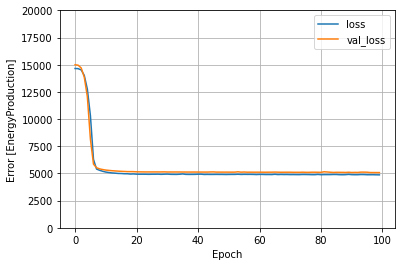

In [548]:
plot_loss(history)

In [549]:
x = tf.linspace(0.0, 50, 51)
y = dnn_solarhours_model.predict(x)

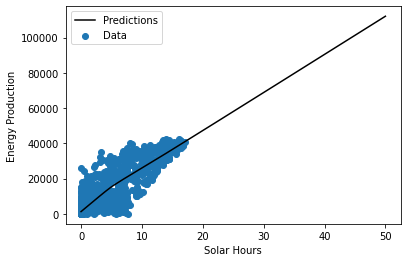

In [550]:
plot_solarhours(x, y)

**Full Model** Slutligen använder vi oss av både datum, soltimmar med en DNN modell.  

In [559]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_16 (Normalizat (None, 8)                 17        
_________________________________________________________________
dense_165 (Dense)            (None, 64)                576       
_________________________________________________________________
dense_166 (Dense)            (None, 128)               8320      
_________________________________________________________________
dense_167 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_168 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_169 (Dense)            (None, 1)                 65        
Total params: 33,746
Trainable params: 33,729
Non-trainable params: 17
________________________________________________

In [560]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=125)

CPU times: user 16.1 s, sys: 711 ms, total: 16.8 s
Wall time: 14.3 s


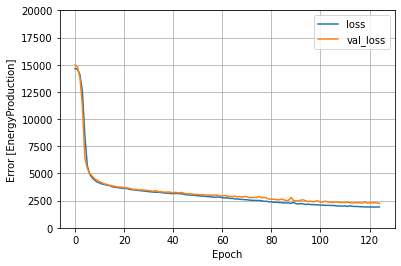

In [561]:
plot_loss(history)

In [562]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [563]:
pd.DataFrame(test_results, index=['Mean absolute error [EnergyProduction]']).T

,Mean absolute error [EnergyProduction]
solarhours_model,14004.234375
linear_model,14000.008789
dnn_model,2489.851074


Make Predictions

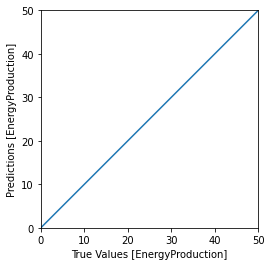

In [556]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [EnergyProduction]')
plt.ylabel('Predictions [EnergyProduction]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

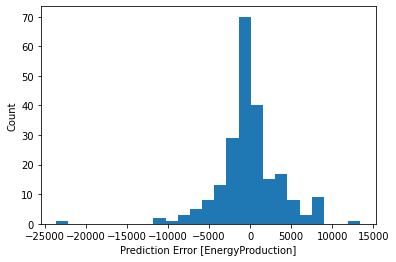

In [557]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [EnergyProduction]')
_ = plt.ylabel('Count')

In [558]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model/assets
